In [21]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchnlp.datasets import multi30k_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_set = multi30k_dataset(train=True)
validation_set = multi30k_dataset(dev=True)
test_set = multi30k_dataset(test=True)

## Loading data file
file format: 
[{'en': 'A man in an orange hat starring at something.', 
'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}, {}]

1. add SOS EOS
2. From unicode to acsii, delete lower case and trim punctuation.

In [50]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20
EPOCH = 10
TRAINING_SIZE = -1

# build the dictionary
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter character
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def buildLangs(train_set, reverse=False):
    """ build Language dictionary
    Input: set and reverse flag. Default file from Eng>De.
        If we want to translate De->Eng, set reverse=True
    Output: two language dictionary class from training set
    """
    train_pairs = [[normalizeString(pair['en']), normalizeString(pair['de'])] \
        for pair in train_set[0:TRAINING_SIZE]]

    if reverse:
        train_pairs = [list(reversed(pair)) for pair in train_pairs]
        input_lang = Lang('en')
        output_lang = Lang('de')
    else: 
        input_lang = Lang('de')
        output_lang = Lang('en')
    return input_lang, output_lang, train_pairs

def prepareData(reverse=False):
    input_lang, output_lang, pairs = buildLangs(train_set, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(reverse=True)
print(random.choice(pairs))

Read 28999 sentence pairs
Counting words...
Counted words:
en 16218
de 9124
['ein pferd geht unter einer brucke neben einem boot .', 'a horse is walking beside a boat under a bridge .']


## Encoder and Decoder layer
A RNN network. Each timestep, input a word and then output a hidden state which used in next timestep input word. Need to implement forward calculation.

In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size) # gated recurrent unit

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # reshape the output
        output =embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # TODO: figure out how to determine the size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training
## Prepare the training data
Set the word to the index tensor.

In [24]:
# get index of word in sentence from dictionary
def indexFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# return index tensor for pair
def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [34]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher = True if random.random() < teacher_forcing_ratio else False

    if use_teacher:
        for de in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[de])
            decoder_input = target_tensor[de]
    else:
        # Without teacher forcing: use its own predictions as the next input
        for de in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[de])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.


In [36]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorFromPair(random.choice(pairs)) for i in range(n_iters)]

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,\
            decoder_optimizer, criterion)
        # print("missing loss:",loss)

        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), \
                iter, iter / n_iters *100, print_loss_avg))
            showPlot(plot_losses)
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [27]:
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    plt.savefig('loss')

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

0m 34s (- 114m 16s) (100 0%) 5.5620
1m 11s (- 117m 24s) (200 1%) 4.8372
1m 46s (- 116m 16s) (300 1%) 4.7999
2m 21s (- 115m 55s) (400 2%) 4.5441
2m 56s (- 114m 52s) (500 2%) 4.6792
3m 33s (- 114m 54s) (600 3%) 4.5867
4m 10s (- 115m 12s) (700 3%) 4.9620
4m 49s (- 115m 39s) (800 4%) 4.7502
5m 27s (- 115m 44s) (900 4%) 4.6554
6m 2s (- 114m 51s) (1000 5%) 4.6746
6m 42s (- 115m 14s) (1100 5%) 4.7445
7m 21s (- 115m 21s) (1200 6%) 4.6518
7m 59s (- 115m 0s) (1300 6%) 4.7911
8m 39s (- 115m 0s) (1400 7%) 4.4300
9m 17s (- 114m 32s) (1500 7%) 4.5448
9m 55s (- 114m 5s) (1600 8%) 4.4475
10m 35s (- 113m 59s) (1700 8%) 4.4007
11m 13s (- 113m 34s) (1800 9%) 4.6455
11m 54s (- 113m 24s) (1900 9%) 4.5106
12m 31s (- 112m 44s) (2000 10%) 4.3172
13m 5s (- 111m 37s) (2100 10%) 4.4646
13m 40s (- 110m 42s) (2200 11%) 4.6120
14m 17s (- 109m 58s) (2300 11%) 4.2987
14m 52s (- 109m 4s) (2400 12%) 4.3918
15m 28s (- 108m 17s) (2500 12%) 4.3094
16m 5s (- 107m 39s) (2600 13%) 4.5284
16m 43s (- 107m 7s) (2700 13%) 4.2520

<Figure size 432x288 with 0 Axes>

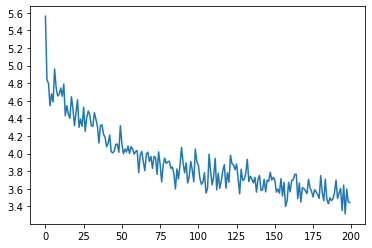

In [37]:
%matplotlib inline

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoder(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trian_set_size = len(train_set)
trainIters(encoder1, attn_decoder1, EPOCH*trian_set_size, print_every=1000)

In [41]:
encoder_save = '/encoder0602.pth'
decoder_save = '/attn0602.pth'
torch.save(encoder1.state_dict(), "./trained_model"+encoder_save)
torch.save(attn_decoder1.state_dict(), "./trained_model"+decoder_save)

In [49]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluateRandomly(encoder1, attn_decoder1)

> ein muder mann schlaft am stra enrand auf seinem motorrad .
= a tired man is sleeping on his motorcycle on the side of the road .
< a man man on on the on the . . . . <EOS>

> ein junge in rot blauer kleidung schwebt in der luft .
= the young boy in the red and blue outfit is poised in midair .
< a boy wearing a red shirt and blue shorts is jumping into the air . <EOS>

> funf manner in asiatisch anmutender gewandung wickeln kleidungsstucke um ihre kopfe wahrend sich im hintergrund menschen unterhalten .
= five men in asian inspired garb wrap clothes around their heads while people converse in the background .
< five men in a red shirts their their their their in their their their the their their . . . people . <EOS>

> ein mann mit einer mutze und einem blauen hemd tut so als ob er ein madchen wurgt .
= a man in a cap and blue shirt pretends to choke a girl .
< a man in a gray and blue hat is a a girl girl . a girl . . . . <EOS>

> ein mann und eine frau trinken etwas und amusieren 

## Set up data for evaluation
Using bleu.perl to evaluate.

Require each line to be a txt.

In [58]:
def dataClean(data_set):
    pairs = [[normalizeString(pair['en']), normalizeString(pair['de'])] \
        for pair in data_set[0:-1]]

    return [pair for pair in pairs if filterPair(pair)]

test_pairs = dataClean(test_set)
print(len(test_pairs))

with open("test_set.txt","w") as f:
    for pair in test_pairs:
        f.write(pair[0]+'\n')

930


In [47]:
"""
fail to run for now
"""
from BLEU.py import *
def run():
    source = '正因为你为你的玫瑰花费了时间,这才使你的玫瑰变得如此重要'  # source
    target = 'What makes your rose so important is the time you have wasted for it.'  # target
    inference = 'It is the time you have wasted for your rose that makes your rose so important.'  # inference
    bleu1 = BLEU(source, target, inference)
    bleu1.evaluate()
run()

ModuleNotFoundError: No module named 'jieba'